League of Legends is a popular Multiplayer Online Battle Arena (MOBA) that is played by more than 100 Million people around the globe. Data is publicly available and can be accessed. The problem is that the data structure is very incovenient (a lot of dictionaries) and a lot of data wrangling is necessary until actual, useful questions can be answered. This project gets data from the Riot Games API.

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import beta, binom
import matplotlib.pyplot as plt

Teams try to find talented players. We want to get stats for the best players (Rank: Challenger) of the Korean server. Teams' scouts might be interested in metrics.


Reading in data from Oracle's Elixir, downloaded on 1-13-2021.

In [20]:
sp_2021_reg, sp_2021_pl, su_2021_reg, su_2021_pl =  pd.read_csv("LCK CL 2021 Spring - Player Stats - OraclesElixir.csv"), pd.read_csv("LCK CL 2021 Spring Playoffs - Player Stats - OraclesElixir.csv"), pd.read_csv("LCK CL 2021 Summer - Player Stats - OraclesElixir.csv"), pd.read_csv("LCK CL 2021 Summer Playoffs - Player Stats - OraclesElixir.csv")

all_splits = [sp_2021_reg, sp_2021_pl, su_2021_reg, su_2021_pl]

all_splits_df = pd.concat(all_splits)

Inspecting one players as an example.

In [21]:
all_splits_df.query('Player == "Berserker"').columns

Index(['Player', 'Team', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
       'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
       'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'STL', 'WPM', 'WCPM'],
      dtype='object')

We want to change some column names to avoid confusion.

In [22]:
all_splits_df = all_splits_df.rename(columns={"K": "total_kills",
"Pos": "position",
 "D": "total_deaths",
  "A": "total_assists",
  "GP": "games_played",
   "W%": "winrate%",
    "CTR%": "pick_after_opponent%",
     "KP":"kill_assist_participation%",
      "KS%":"kill_participation%",
      "DTH%":"average_share_teams_deaths%",
      "FB%": "first_blood_participation_rate%",
      "GD10": "average_gold_diff_10_min",
      "XPD10": "average_xp_diff_10_min",
      "CSD10": "average_cs_diff_10_min",
      "CSPM": "average_CSPM",
      "CS%P15": "average_share_team_cs_post_15_min%",
      "DPM": "average_DPM_to_champs",
      "DMG%": "average_share_team_DMG_to_champs%",
      "D%P15": "average_share_team_DMG_to_champs_post_15_min%",
      "EGPM": "average_gold_per_min",
      "GOLD%": "average_share_team_gold%",
      "STL": "num_neutral_obj_stolen",
      "WPM": "average_wards_per_min",
      "WCPM": "average_wards_cleared_per_min"})

Inspecting the resulting column names and their datatypes. 

In [23]:
all_splits_df.dtypes

Player                                            object
Team                                              object
position                                          object
games_played                                       int64
winrate%                                          object
pick_after_opponent%                              object
total_kills                                        int64
total_deaths                                       int64
total_assists                                      int64
KDA                                              float64
kill_assist_participation%                        object
kill_participation%                               object
average_share_teams_deaths%                       object
first_blood_participation_rate%                   object
average_gold_diff_10_min                           int64
average_xp_diff_10_min                             int64
average_cs_diff_10_min                           float64
average_CSPM                   

All columns that are measured in percent are not recognized as numeric columns, but as object columns. In order to use mathematical operations with these columns, they have to be transformed to numeric columns.

In [24]:
all_splits_df['winrate%'].str.rstrip('%')

#all_splits_df.astype({'winrate%' : 'float64'})

0     55
1     83
2     63
3     83
4     42
      ..
28    40
29    40
30    44
31    50
32    50
Name: winrate%, Length: 195, dtype: object

As we have seen above, some players participated in more than one split, we have to aggregate their data, such that we end up with one row for every player. We want to keep non-performance related features, as they are in the raw data: this includes the player name, his team, his position and the number of games played. Some metrics allow for just averaging over them (e.g. all averaged metrics). This is possible, as these metrics refer to an average game of a player in one split, i.e. playoff. Thus, taking their mean just means that the value now represents the average game of all tournaments, a player took part in. However, this can not be done for absolute measures who refer to a whole tournaments, such as kills. This is due to the fact that certain players have participated in different tournaments that had a different amount of games. This questions the general use of absolute measures.

We are gonna create lists that specify columns that will be aggregated in the same way: one list for the columns that will be summed, one list for the columns that will be averaged, and finally, one list for the remaining, non-numerical, columns.

In [25]:
cols_to_sum = ['games_played',
 'total_kills', 'total_deaths',
  'total_assists', 'num_neutral_obj_stolen']

cols_to_keep = ['Player','Team', 'position']

cols_to_avg = [col for col in all_splits_df.columns if col not in (cols_to_sum + cols_to_keep)]

Transforming string columns that are stored in % to numerical columns, before grouping and performing the aggregation.

In [26]:
percentage_cols = [col for col in cols_to_avg if col.endswith("%")]

all_splits_df_percentage_cols = all_splits_df[percentage_cols].astype(str).applymap(lambda x: x.strip("%"))



all_splits_df = pd.concat([all_splits_df.drop(percentage_cols, axis = 1),
 all_splits_df_percentage_cols.astype('float16')], axis = 1)

In [27]:
all_splits_df.dtypes

Player                                            object
Team                                              object
position                                          object
games_played                                       int64
total_kills                                        int64
total_deaths                                       int64
total_assists                                      int64
KDA                                              float64
average_gold_diff_10_min                           int64
average_xp_diff_10_min                             int64
average_cs_diff_10_min                           float64
average_CSPM                                     float64
average_DPM_to_champs                              int64
average_gold_per_min                               int64
num_neutral_obj_stolen                           float64
average_wards_per_min                            float64
average_wards_cleared_per_min                    float64
winrate%                       

Grouping and aggregating.

In [28]:
all_splits_by_player = all_splits_df.groupby(['Player'])

orig_cols = all_splits_df[cols_to_keep].drop_duplicates('Player')
summed_cols = all_splits_by_player[cols_to_sum].sum()


avg_cols = all_splits_by_player[cols_to_avg].mean()



 Concatenating the dfs. 

In [29]:
orig_summed_cols = pd.concat([orig_cols.set_index('Player'), summed_cols], axis = 1)
agg_all = pd.concat([orig_summed_cols, avg_cols], axis = 1)

Unfortunately, the metrics are still biased by the team and the position of a player. One should not compare the number of kills of a support and of an attack damage carry (ADC). This can be easily be taken care of by grouping by positions.
Added to that, two players that feature the same characteristics (e.g. ability) will have different metrics. This is due to the fact that if one player is on the worst team, while the other is on the best team, he will score less kills, for example. Therefore, it is also indispensable to account for the relative rank of a player's team. In order to minimize the team's effect, we will conduct statistical tests to compare the performance of teams. Then, if a team's performance (m games won out of n games) is not statistically different from another team's, we consider then to be similar, allowing for comparison of players. First, we have to compute a team's performance. This can be done by looking at the player of the team that has played most games for it, serving as an estimate for m and n.

In [30]:
teams = agg_all.groupby(['Team']).max('games_played')

teams = teams.assign(wins = (teams['winrate%'] / 100) * teams['games_played']).astype(int)

win_stats = teams[['wins', 'winrate%', 'games_played']].sort_values(by=['winrate%'], ascending = False)

win_stats

,wins,winrate%,games_played
Team,,,
Gen.G Challengers,39,76,51
DWG KIA Challengers,27,75,36
Kwangdong Freecs Challengers,25,71,36
T1 Challengers,29,70,42
Nongshim RedForce Challengers,28,59,48
KT Rolster Challengers,27,57,48
Hanwha Life Esports Challengers,26,52,50
DRX Challengers,24,50,48
Liiv SANDBOX Challengers,21,47,46


By descriptively looking at the teams, I would suggest three groups: Gen.G, DWG, Freecs and T1 form the best teams, followed by mid tier teams Nongshim and KT. Lastly, we have the rest of the teams whose winrate is very close to 50% only. Unfortunately, group wise comparison would be quite difficult with two groups only, as in the worst case scenario, we would only have two players in each position to compare in the mid tier group. What does testing suggest?

#### Hypothesis testing
$H_0: w_0 = ... = w_9 $

A standard testing procedure comparing all win rates, simultaneously, would not really help to solve to this problem, as it is super likely that we would reject the $H_0$ just due to Fredit and Gen.G's difference. We would not gain a lot of additional insight, as we don't statistical evidence for this difference (the worst team and the best team are just different). Therefore, it is necessary to think about a more useful approach. It would be possible to do pair wise comparisons instead. Then, however, one has to consider the type-1-error inflation, by implementing, for instance, the Bonferroni correction. \
Pair-wise comparisons can be done by doing Binomial tests, as we are having one binomial distribution for every team. We want to know whether these distributions differ.

$p(w_i | m_i , n_i ) =  \frac{p(m_i , n_i | w_i) * p(w_i)}
    {\int p(m_i , n_i | w_a) * p(w_a) dw_a}$

Let's do Bayesian inference to get a posterior for the winrate of every team. The prior should be a distribution that suggests, most frequently, a winrate of 50%, as I would assume, before seeing any data that each team will perform similarly well, while some teams are worse and some teams are better. We want to use a Beta prior:

$p(w_i) = \frac{(w_i)^{a-1} (1-w_i)^{b-1}}{B(a,b)}$

Creating a function that plots a beta distribution, which is parameterized by a and b:

In [49]:
def plot_beta_prior(a:float, b:float):

    prior = beta(a,b)

    mm = np.linspace(0, 1, 500)

    fig,ax = plt.subplots(1,1, figsize=(10, 4),dpi=150)
    
    ax.vlines(mm,0,prior.pdf(mm))   



A symmetric beta distribution manifests the belief that the most frequent winrate is 50%:

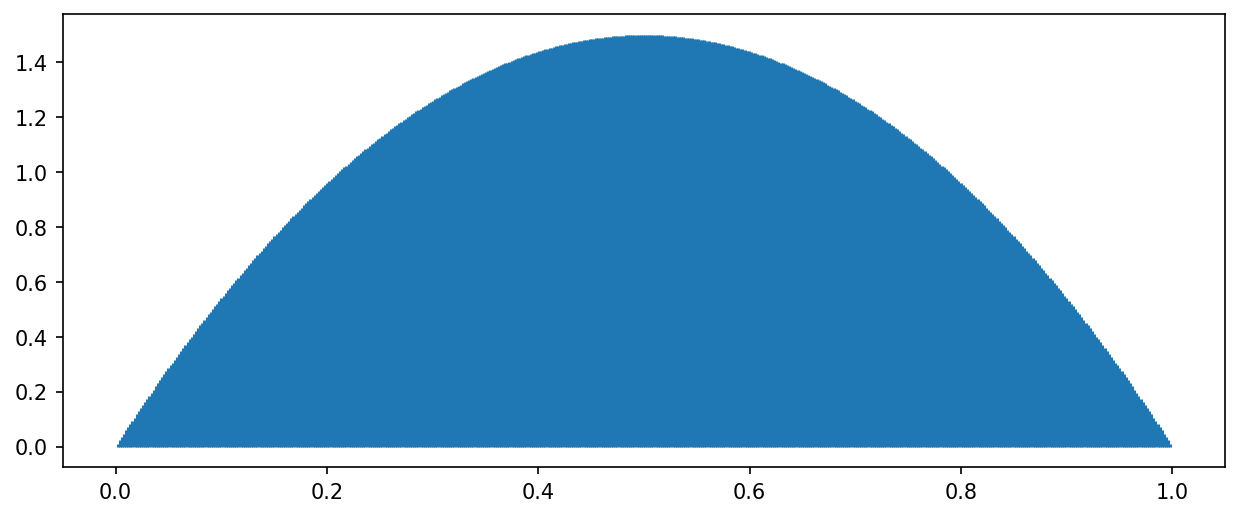

In [50]:
plot_beta_prior(2,2)

As mentioned above, we are having a Binomial likelihood:

$p(m_i , n_i | w_i) = {n_i\choose m_i} w_{i}^{m_i} (1 - w_i)^{n_i - m_i}$

Creating a function that plots a binomial distribution:

In [ ]:
def plot_binomial_likelihood(n:int, w:float):

    grid = np.arange(n_1)

    fig,ax = plt.subplots(1,1, figsize=(10, 4),dpi=150)
    ax.vlines(grid, 0, binom.pmf(grid, n, w))   


For Gen.G, this looks like:

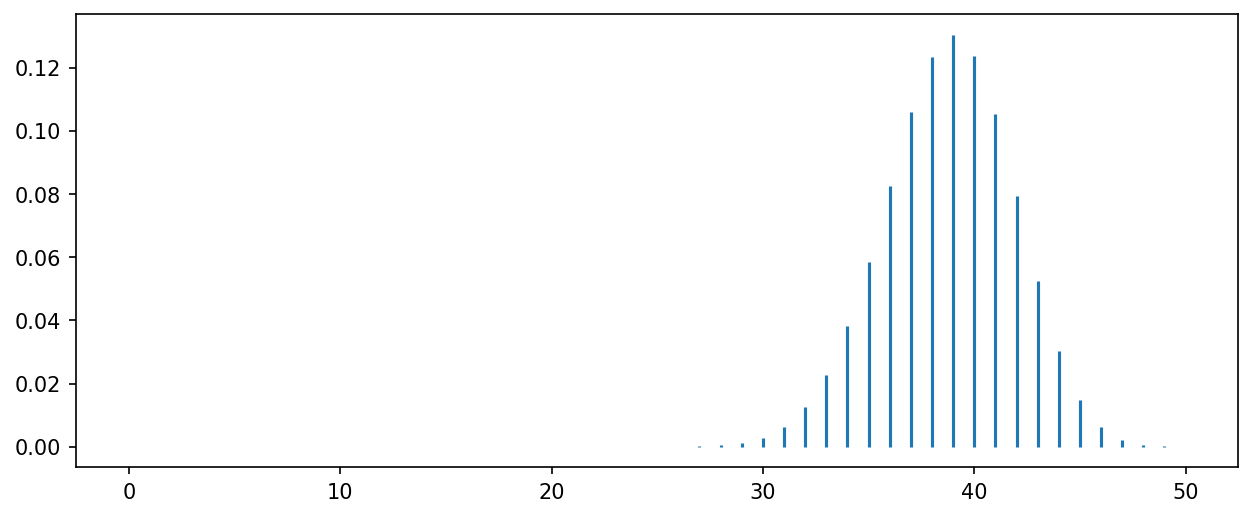

In [55]:
n_1 = win_stats.loc['Gen.G Challengers'].games_played
w_1 = win_stats.loc['Gen.G Challengers'][['winrate%']]/100
m_1 = win_stats.loc['Gen.G Challengers'].wins

plot_binomial_likelihood(n_1, w_1)


The Beta distribution is a conjugate prior for the Binomial distribution, which means that we can write down the posterior in the following closed form:

$p(w_i | m_i , n_i ) = \frac{(w_i)^{a - 1 + m_i} (1-w_i)^{b- 1+ n_i - m_i}}{B(a + m_i; b - n_i + m_i )}$

Creating a function that plots the probability density function (PDF) of a posterior (beta distribution), which is parameterized by $a' = a + m_i$ and $b' = b - n_i + m_i$:

In [ ]:
def plot_beta_posterior(m_i:int, n_i:int, a:float, b:float):

    posterior = beta(a + m_i, b + n_1 - m_i)

    mm = np.linspace(0, 1, 500)

    fig,ax = plt.subplots(1,1, figsize=(10, 4),dpi=150)
    ax.vlines(mm,0,posterior.pdf(mm))

Gen G's posterior then does look like:

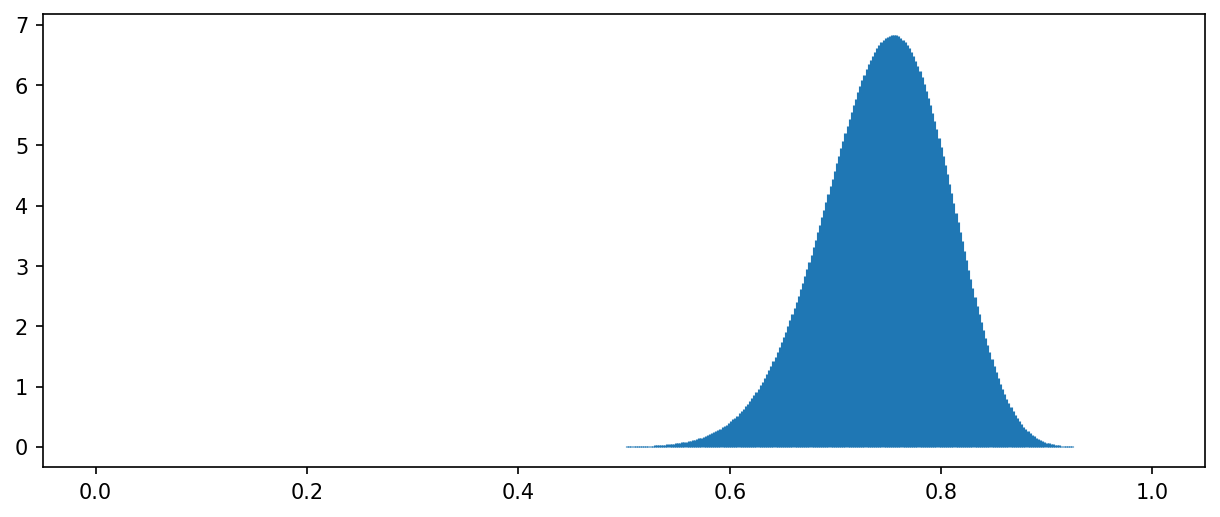

In [56]:
plot_beta_posterior(m_1, n_1, 2, 2)

In [34]:
win_stats_formalized = win_stats.rename(columns={"wins": "m_i", "winrate%": "w_i", "games_played": "n_i"})

win_stats_formalized

,m_i,w_i,n_i
Team,,,
Gen.G Challengers,39,76,51
DWG KIA Challengers,27,75,36
Kwangdong Freecs Challengers,25,71,36
T1 Challengers,29,70,42
Nongshim RedForce Challengers,28,59,48
KT Rolster Challengers,27,57,48
Hanwha Life Esports Challengers,26,52,50
DRX Challengers,24,50,48
Liiv SANDBOX Challengers,21,47,46


To account for the bias in the KPIs (an ADC will deal more damage than a support) caused by positions, the data should be grouped by the position of the player.

In [39]:
agg_all.position

5kid             ADC
Asper        Support
Baut         Support
Berserker        ADC
Bini             ADC
              ...   
Willer        Jungle
SOLKA         Middle
TaNa             Top
Pleata       Support
Bible        Support
Name: position, Length: 80, dtype: object

In [40]:
Middle = agg_all.query('position == "Middle"')

Middle[['KDA', 'total_kills', 'total_deaths', 'total_assists']].assign(KDA_custom =
 (Middle['total_kills'] + Middle['total_assists'])/Middle['total_deaths'])

,KDA,total_kills,total_deaths,total_assists,KDA_custom
Cruiser,1.500000,1,4,5,1.500000
Dice,3.500000,47,34,75,3.588235
Eign,2.633333,108,115,211,2.773913
FIESTA,2.433333,80,99,176,2.585859
Jool,3.050000,69,90,184,2.811111
Keine,3.433333,89,64,132,3.453125
Mask,4.200000,144,105,292,4.152381
Mireu,4.100000,149,124,300,3.620968
Ophelia,3.866667,56,50,156,4.240000
Roamer,4.100000,131,97,267,4.103093


In [36]:
top = agg_all.query('position == "Top"')

top[['KDA', 'total_kills', 'total_deaths', 'total_assists']].assign(KDA_custom =
 (top['total_kills'] + top['total_assists'])/top['total_deaths'])

,KDA,total_kills,total_deaths,total_assists,KDA_custom
Castle,3.150000,114,103,257,3.601942
Chasy,3.200000,88,64,120,3.250000
Clear,2.875000,134,144,258,2.722222
DnDn,2.800000,119,128,248,2.867188
Howling,3.150000,26,30,63,2.966667
Lonely,4.200000,139,108,334,4.379630
Lukalux,2.800000,25,53,123,2.792453
Photon,2.575000,105,86,167,3.162791
Riss,2.833333,112,125,213,2.600000
Roach,4.766667,113,107,272,3.598131
